# Modeling

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, PrecisionRecallDisplay, precision_recall_curve
from sklearn.base import clone
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
sys.path.append("../src")
import utils

# rng = np.random.default_rng(10)

## 0. Preface

As an introduction to the scope of the problem, let's begin by fitting a logistic regression with default parameters on the (smaller) balanced data. This is done in the next two code cells. The third code presents metrics for the model: classification reports for both training and test data, and a detail of the precision-recall curve for the testing data. These show a model that is able to catch fraud cases in the test data only at the expense of a large number of false positives: catching three quarters of fraud cases requires almost 50 false positives for every accurate fraud label.

The question, then, is how much lower can we get this false positive rate while still flagging a large share of fraudulent transactions for further investigation? This last point is important: a "false positive" can mean, in practice, declining a transaction until it is confirmed by the user, for example by responding to a text message. This is certainly a nuisance for customers, but it can be weighed against the benefit of preemptively catching a larger share of fraudulent activity.

In [27]:
# load balanced training data and test data
X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'), index_col=0)
X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'), index_col=0)

y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((27599, 27), (1176707, 27), (27599,), (1176707,))

## 1. Framework

This section sets up the models and parameter grids that will be assessed below. All information on models will be combined into list of dictionaries, each with the following elements:
1. `name`: A descriptive name
1. `estimator`: The full model pipeline, including needed transformations. Each pipeline consists of the replacement of `MCC` codes, the conversion of categorical variables (with or without drop-first dummy encoding), and standardization if necessary.
1. `paramaters`: A dictionary to be passed to `RandomSearchCV` for hyperparameter tuning.
1. `gridsize`: An integer indicating how many unique combinations of parameters there are. This will be used to determine the kind of search to perform.

In [28]:
# Shared transformers
mcc_convert = utils.MCCRates()
cat_convert_dummies = utils.MakeDummies('errors')
cat_convert_onehot = utils.MakeDummies('errors', drop_first=False)
standardize = StandardScaler()
# List containing the model information dictionaries
models = {}

def make_pipe_params(name, params):
    '''Appends the model name for setting parameters in a pipeline'''
    return {f'{name}__{key}':value for key, value in params.items()}

def gridsize(params):
    '''Counts the number of hyperparameters. Return a tuple of (number unique combinations, number of distinct values)'''
    total_prod = 1
    total_sum = 0
    for _, vals in params.items():
        total_prod *= len(vals)
        total_sum += len(vals)
    return total_prod, total_sum

def model_dict(name, components, params):
    return {
        'pipeline': make_pipeline(*components),
        'parameters': make_pipe_params(name, params),
        'gridsize': gridsize(params)
    }

### XGBoost

Does not require drop-first encoding or standardization. Hyperparameters:
- Learning rate: `1e-2...1e1`
- Max depth of trees: 2, 4, 8, 16, 32
- Minimum child weight: 1, 10, 20, 30

In [29]:
name = 'xgbclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    XGBClassifier(objective='binary:logistic')
]

parameters = {
    'learning_rate': [0.01*(x+1) for x in range(100)],
    'max_depth': [2*2**(x+1) for x in range(5)],
    'min_child_weight': [1, 10, 20, 30],
    'subsample': [0.5, 0.75, 1.0],
    'reg_lambda': [0., 1., 2.],
    'reg_alpha': [0., 1., 2.]
}

models[name] = model_dict(name, components, parameters)

default_xgb = models['xgbclassifier']['pipeline'].fit(X_train, y_train)

## 2. Tuning

This section measured the performance of the various model and hyperparamter combinations with 5-fold cross-validation, using both search and Bayesian optimization. Model performance is measured with F1 scores, because not every model can output probabilities. The best-performing estimators for each model from each tuning method are then saved for evaluation later.

In [30]:
# Loading data

X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'), index_col=0)
y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

### 2.2 Bayesian Optimization

As an alternative method, we can employ Bayesian Optimization. The code in the following cells converts the parameter grids to parameter ranges and does the setup needed to handled categorical parameters. Note that for parameters like learning rates that are typically searched on a logarithmic scale, the wrapper class converts accordingly.

The optimization is carried out with 10 random initialization and 50 optimization steps.

In [31]:
class BayesOptWrapper():
    def __init__(self, pipeline, parameters) -> None:
        # make parameter dictionary formatted for BayesOpt and converter to pass to model
        self.opt_params = {}
        self.param_converters = {}
        for param, values in parameters.items():
            ints = []
            floats = []
            categories = []
            for val in values:
                if type(val) == str or type(val) == type(None):
                    categories.append(val)
                elif type(val) == int:
                    ints.append(val)
                elif type(val) == float:
                    floats.append(val)
            if len(categories) == 0:
                # only numerical values
                if len(floats) > 0:
                    # use log scale for parameters expected to be in (0,1)
                    if min(floats)>0 and max(floats)<1:
                        self.opt_params[param] = (np.log(min(ints+floats)), np.log(max(ints+floats)))
                        self.param_converters[param] = lambda val: np.exp(val)
                    else:
                        self.opt_params[param] = (min(ints + floats), max(ints + floats))
                        self.param_converters[param] = lambda val: val
                else: # only integers, so truncate
                    self.opt_params[param] = (min(ints), max(ints)+.9999)
                    self.param_converters[param] = lambda val: int(val)
            elif len(categories) == 1: # one category and integers (e.g. None): treat 0 as that category
                cat_val = categories[0]
                self.opt_params[param] = (0, max(ints)+0.9999) # because int() truncates
                if len(floats) > 0:
                    raise ValueError('Cannot combine category with floats')
                else:
                    self.param_converters[param] = lambda val, cat_val=cat_val: cat_val if int(val) == 0 else int(val)
            else:
                # treat all of the options as categories
                categories += floats + ints
                self.opt_params[param] = (0, len(categories)-0.0001) # ensure valid indices with truncating
                self.param_converters[param] = lambda val, categories=categories.copy(): categories[int(val)]
        
        # save a copy of the estimator pipeline
        self.estimator = clone(pipeline)


    def convert_params(self, **parameters):
        '''Take the floating point parameters generated by BayesOpt and converts them to the appropriate values for the model (e.g. integers or strings)'''
        return {param:self.param_converters[param](val) for param, val in parameters.items()}

    
    def optimize(self, X, y, init_points, n_iter):
        '''Returns tuple of best score, dict of best parameters, and optimized estimator'''
        # make cv scorer function
        scorer = lambda **parameters: np.mean(cross_val_score(
            self.estimator.set_params(**self.convert_params(**parameters)), 
            X, 
            y, 
            scoring='f1',
            n_jobs=-1,
            cv=5))
        self.optimizer = BayesianOptimization(
            f = scorer,
            pbounds = self.opt_params,
            verbose = 1,
            allow_duplicate_points=True
        )
        self.optimizer.maximize(init_points=init_points, n_iter=n_iter)
        best_params = self.convert_params(**self.optimizer.max['params']) # type:ignore
        refit_model = clone(self.estimator).set_params(**best_params)
        refit_model.fit(X, y)
        return self.optimizer.max['target'], best_params, refit_model

In [32]:
bayes_opt_results = {}
for name, model in models.items():
    if name=='naive': continue
    print(f'******{name}******')
    optimizer = BayesOptWrapper(model['pipeline'], model['parameters'])
    best_score, best_params, best_estimator = optimizer.optimize(X_train, y_train, 20, 100)
    bayes_opt_results[name] = {
        'best_score': best_score,
        'best_params': best_params,
        'best_estimator': best_estimator
    }

******xgbclassifier******
|   iter    |  target   | xgbcla... | xgbcla... | xgbcla... | xgbcla... | xgbcla... | xgbcla... |
-------------------------------------------------------------------------------------------------
| 5         | 0.9124    | 0.1091    | 56.23     | 22.85     | 0.06401   | 0.3354    | 0.8479    |
| 10        | 0.9145    | 0.07007   | 63.08     | 15.52     | 1.821     | 1.062     | 0.6627    |
| 14        | 0.9149    | 0.1439    | 14.35     | 30.87     | 1.244     | 0.5893    | 0.6632    |
| 18        | 0.9175    | 0.1444    | 59.91     | 29.35     | 1.697     | 0.6104    | 0.6531    |
| 19        | 0.9254    | 0.03346   | 56.89     | 18.03     | 1.515     | 0.103     | 0.9446    |


### 2.3 Cleanup

In [33]:
# delete the training data to free up memory

del X_train, y_train

## 3. Evaluation

To compare the results of the different kinds of models, the code below outputs 3 set of metrics, all using the held-back test data:
1. A classification performance table using a 0.5 probability theshold.
1. A precision-recall curve, zoomed on the portion above 50% recall. The red line in these graphs marks 75% recall.
1. Comparing the precision of each model with 75% recall. This is express both as a rate and as the number of false positives per accurately caught instance of fraud.

In [34]:
def assess_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    test_fraud_prob = model.predict_proba(X_test)[:,1]

    # precision-recall plot
    # _ = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    _ = PrecisionRecallDisplay.from_predictions(y_test, test_fraud_prob)
    plt.axvline(0.75, color='red');
    plt.axis([0.5, 1., 0., 0.25]);
    plt.legend(loc='upper right');
    plt.title(f"Precision-Recall Curve for {name}");
    
    # save precision-recall table
    precision, recall, thresholds = precision_recall_curve(y_test, test_fraud_prob)
    prc = pd.DataFrame({
        'precision':precision[:-1],
        'recall': recall[:-1]},
        index=thresholds
    )
    return prc[prc.recall>=0.75].precision.max()

X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'), index_col=0)
y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
names = []
prec75 = []

              precision    recall  f1-score   support

       False       1.00      0.95      0.97   1175292
        True       0.02      0.91      0.04      1415

    accuracy                           0.95   1176707
   macro avg       0.51      0.93      0.51   1176707
weighted avg       1.00      0.95      0.97   1176707



0.08448015273247951

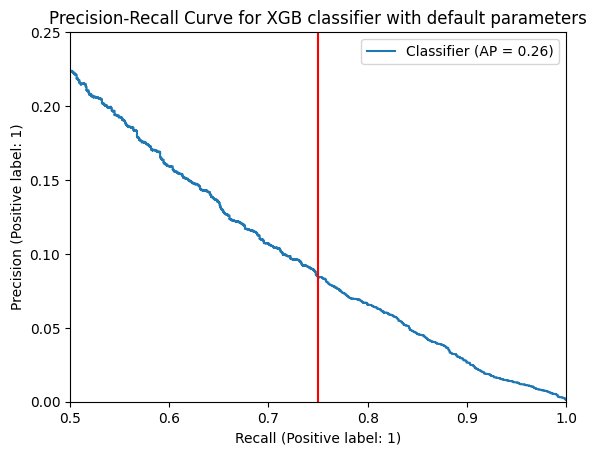

In [35]:
assess_model(default_xgb, "XGB classifier with default parameters", X_test, y_test)

The Bayesian Optimized models.

********xgbclassifier********
xgbclassifier__learning_rate        0.033464
xgbclassifier__max_depth           56.000000
xgbclassifier__min_child_weight    18.000000
xgbclassifier__reg_alpha            1.514965
xgbclassifier__reg_lambda           0.103019
xgbclassifier__subsample            0.944555
dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.94      0.97   1175292
        True       0.02      0.93      0.03      1415

    accuracy                           0.94   1176707
   macro avg       0.51      0.93      0.50   1176707
weighted avg       1.00      0.94      0.97   1176707




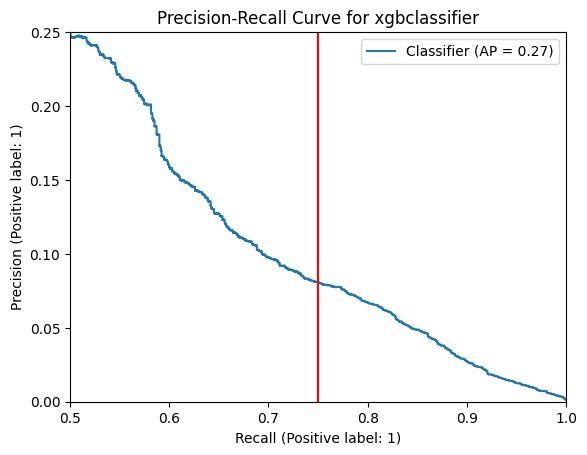

In [36]:
for name, results in bayes_opt_results.items():
    if name=='naive': continue
    print(f'********{name}********')
    print(pd.Series(results['best_params']))
    results['prec75'] = assess_model(results['best_estimator'], name, X_test, y_test)
    names.append(name+'_BayesOpt')
    prec75.append(results['prec75'])
    print()

All of the models sorted by precision at 75% recall.

In [37]:
recall_data = pd.DataFrame({'names': names, 'prec75':prec75})
recall_data['false_positives_per_true'] = 1/ recall_data.prec75 - 1
recall_data.sort_values('prec75', ascending=False)

,names,prec75,false_positives_per_true
0,xgbclassifier_BayesOpt,0.08084,11.370056


The result is that ensemble methods strongly out-perform the linear methods, and in particular, XGBoost does substantially better than any alternative. Tuned using Bayesian optimization, it has just over 9 false postives for every true when catching 75% of fraud cases. This is still far from adequate if the goal were to be to definitively identify instances of fraud. But as a warning flag to at least consider further investigation or confirmation from the customer, it is an immense improvement from a naive "needle in the haystack" approach.

Alternatively, if the preference is to ensure higher precision, the Bayesian-tuned XBoost model can catch about a quarter of fraud cases while flagging about one false positive per correct prediction.

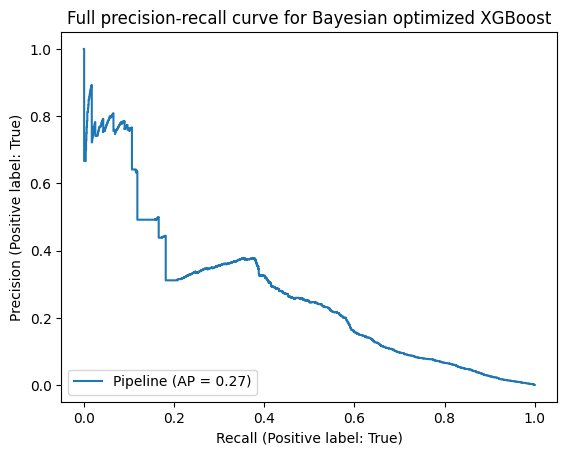

In [38]:
_ = PrecisionRecallDisplay.from_estimator(bayes_opt_results['xgbclassifier']['best_estimator'], X_test, y_test)
_ = plt.title('Full precision-recall curve for Bayesian optimized XGBoost')

Saving the best model.

In [39]:
utils.save_model('xgbclassifier_bayesopt_new', bayes_opt_results['xgbclassifier'])